<a href="https://colab.research.google.com/github/Alex112525/LangGraph-notebooks/blob/main/Chatbot_summarization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install langgraph langgraph-sdk langgraph-checkpoint-sqlite langsmith langchain-community langchain-core langchain-openai

In [2]:
import os
from google.colab import userdata
from IPython.display import Image, display

In [3]:
from langchain_openai import AzureChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage, RemoveMessage

from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver

In [4]:
#Azure OpenAI
os.environ["AZURE_OPENAI_API_KEY"] = userdata.get('Azure_openai')
os.environ["AZURE_OPENAI_ENDPOINT"] = userdata.get('Endpoint_openai')

#LangSmith
os.environ["LANGCHAIN_API_KEY"] = userdata.get('LangSmith')
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "summary-memory"

### Utils Funtions

In [5]:
def get_model(model:str="DASH-mini", temp:float=0.1, max_tokens:int=100):
  """Get model from Azure OpenAI"""
  model = AzureChatOpenAI(
        openai_api_version="2024-02-15-preview",
        azure_deployment=model,
        temperature=temp,
        max_tokens=max_tokens,
    )
  return model

In [6]:
gpt4o_mini = get_model(max_tokens=500)
summary_model = get_model(max_tokens=300)

### Memory

In [7]:
# Schema to save the memory
class State(MessagesState):
  summary: str

In [8]:
# Logic to call model
def call_model(state: State):
  summary = state.get("summary", "")

  if summary:
    #add summary to system message
    system_message = f"Summary of the conversation earlier: {summary}"

    messages = [SystemMessage(content=system_message)] + state["messages"]
  else:
    messages = state["messages"]

  response = gpt4o_mini.invoke(messages)
  return {"messages": response}

In [9]:
def summarize_conversation(state: State):

  summary = state.get("summary", "")

  # Summarization prompt
  if summary:
    summary_message = f"This is a summary of the conversation so far: {summary}\n\n" + "In less than 300 words, expand the summary to include the new messages above, keeping the key points like names or topics."

  else:
    summary_message = "Write a summary of the above conversation in less than 300 words, keeping the key points like names or topics."

  # Add prompt to our history
  messages = state["messages"] + [SystemMessage(content=summary_message)]
  response = summary_model.invoke(messages)

  # Keep 2 most recent messages
  new_n_messages = [RemoveMessage(m.id) for m in state["messages"][:-2]]
  return {"summary": response.content, "messages": new_n_messages}

In [10]:
# Determine whether to end or summarize the conversation
def should_summarize(state:State):
  """Return the next node to continue"""

  if len(state["messages"]) > 4:
    return "Sumarize conversation"
  return END

### Agent with sumarized conversation

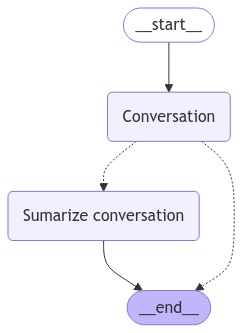

In [11]:
# Define graph
workflow = StateGraph(State)
workflow.add_node("Conversation", call_model)
workflow.add_node("Sumarize conversation", summarize_conversation)

# Set entrypoint as conversation
workflow.add_edge(START, "Conversation")
workflow.add_conditional_edges("Conversation", should_summarize)
workflow.add_edge("Sumarize conversation", END)

# Compile
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [12]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}

In [13]:
def call_agent(msg:str):
  input_message = HumanMessage(content=msg)
  output = graph.invoke({"messages": [input_message]}, config)

  for m in output['messages'][-1:]:
      m.pretty_print()

In [14]:
# Start conversation
call_agent("hi! I'm Alex")

================================== Ai Message ==================================

Hi Alex! How can I assist you today?


In [15]:
call_agent("How are you? ")

================================== Ai Message ==================================

I'm just a program, but I'm here and ready to help! How about you? How are you doing?


In [16]:
call_agent("Really good, learning Langgraph")

================================== Ai Message ==================================

That sounds interesting! Langgraph is a great tool for working with language models and understanding their structures. What specifically are you learning about it?


In [17]:
graph.get_state(config).values.get("summary")

"In a conversation between Alex and an AI, Alex greets the AI and asks how it is doing. The AI responds that it is functioning well and inquires about Alex's well-being. Alex shares that they are doing really well and are currently learning about Langgraph. The AI expresses interest in Langgraph and asks for more details about what Alex is specifically learning."

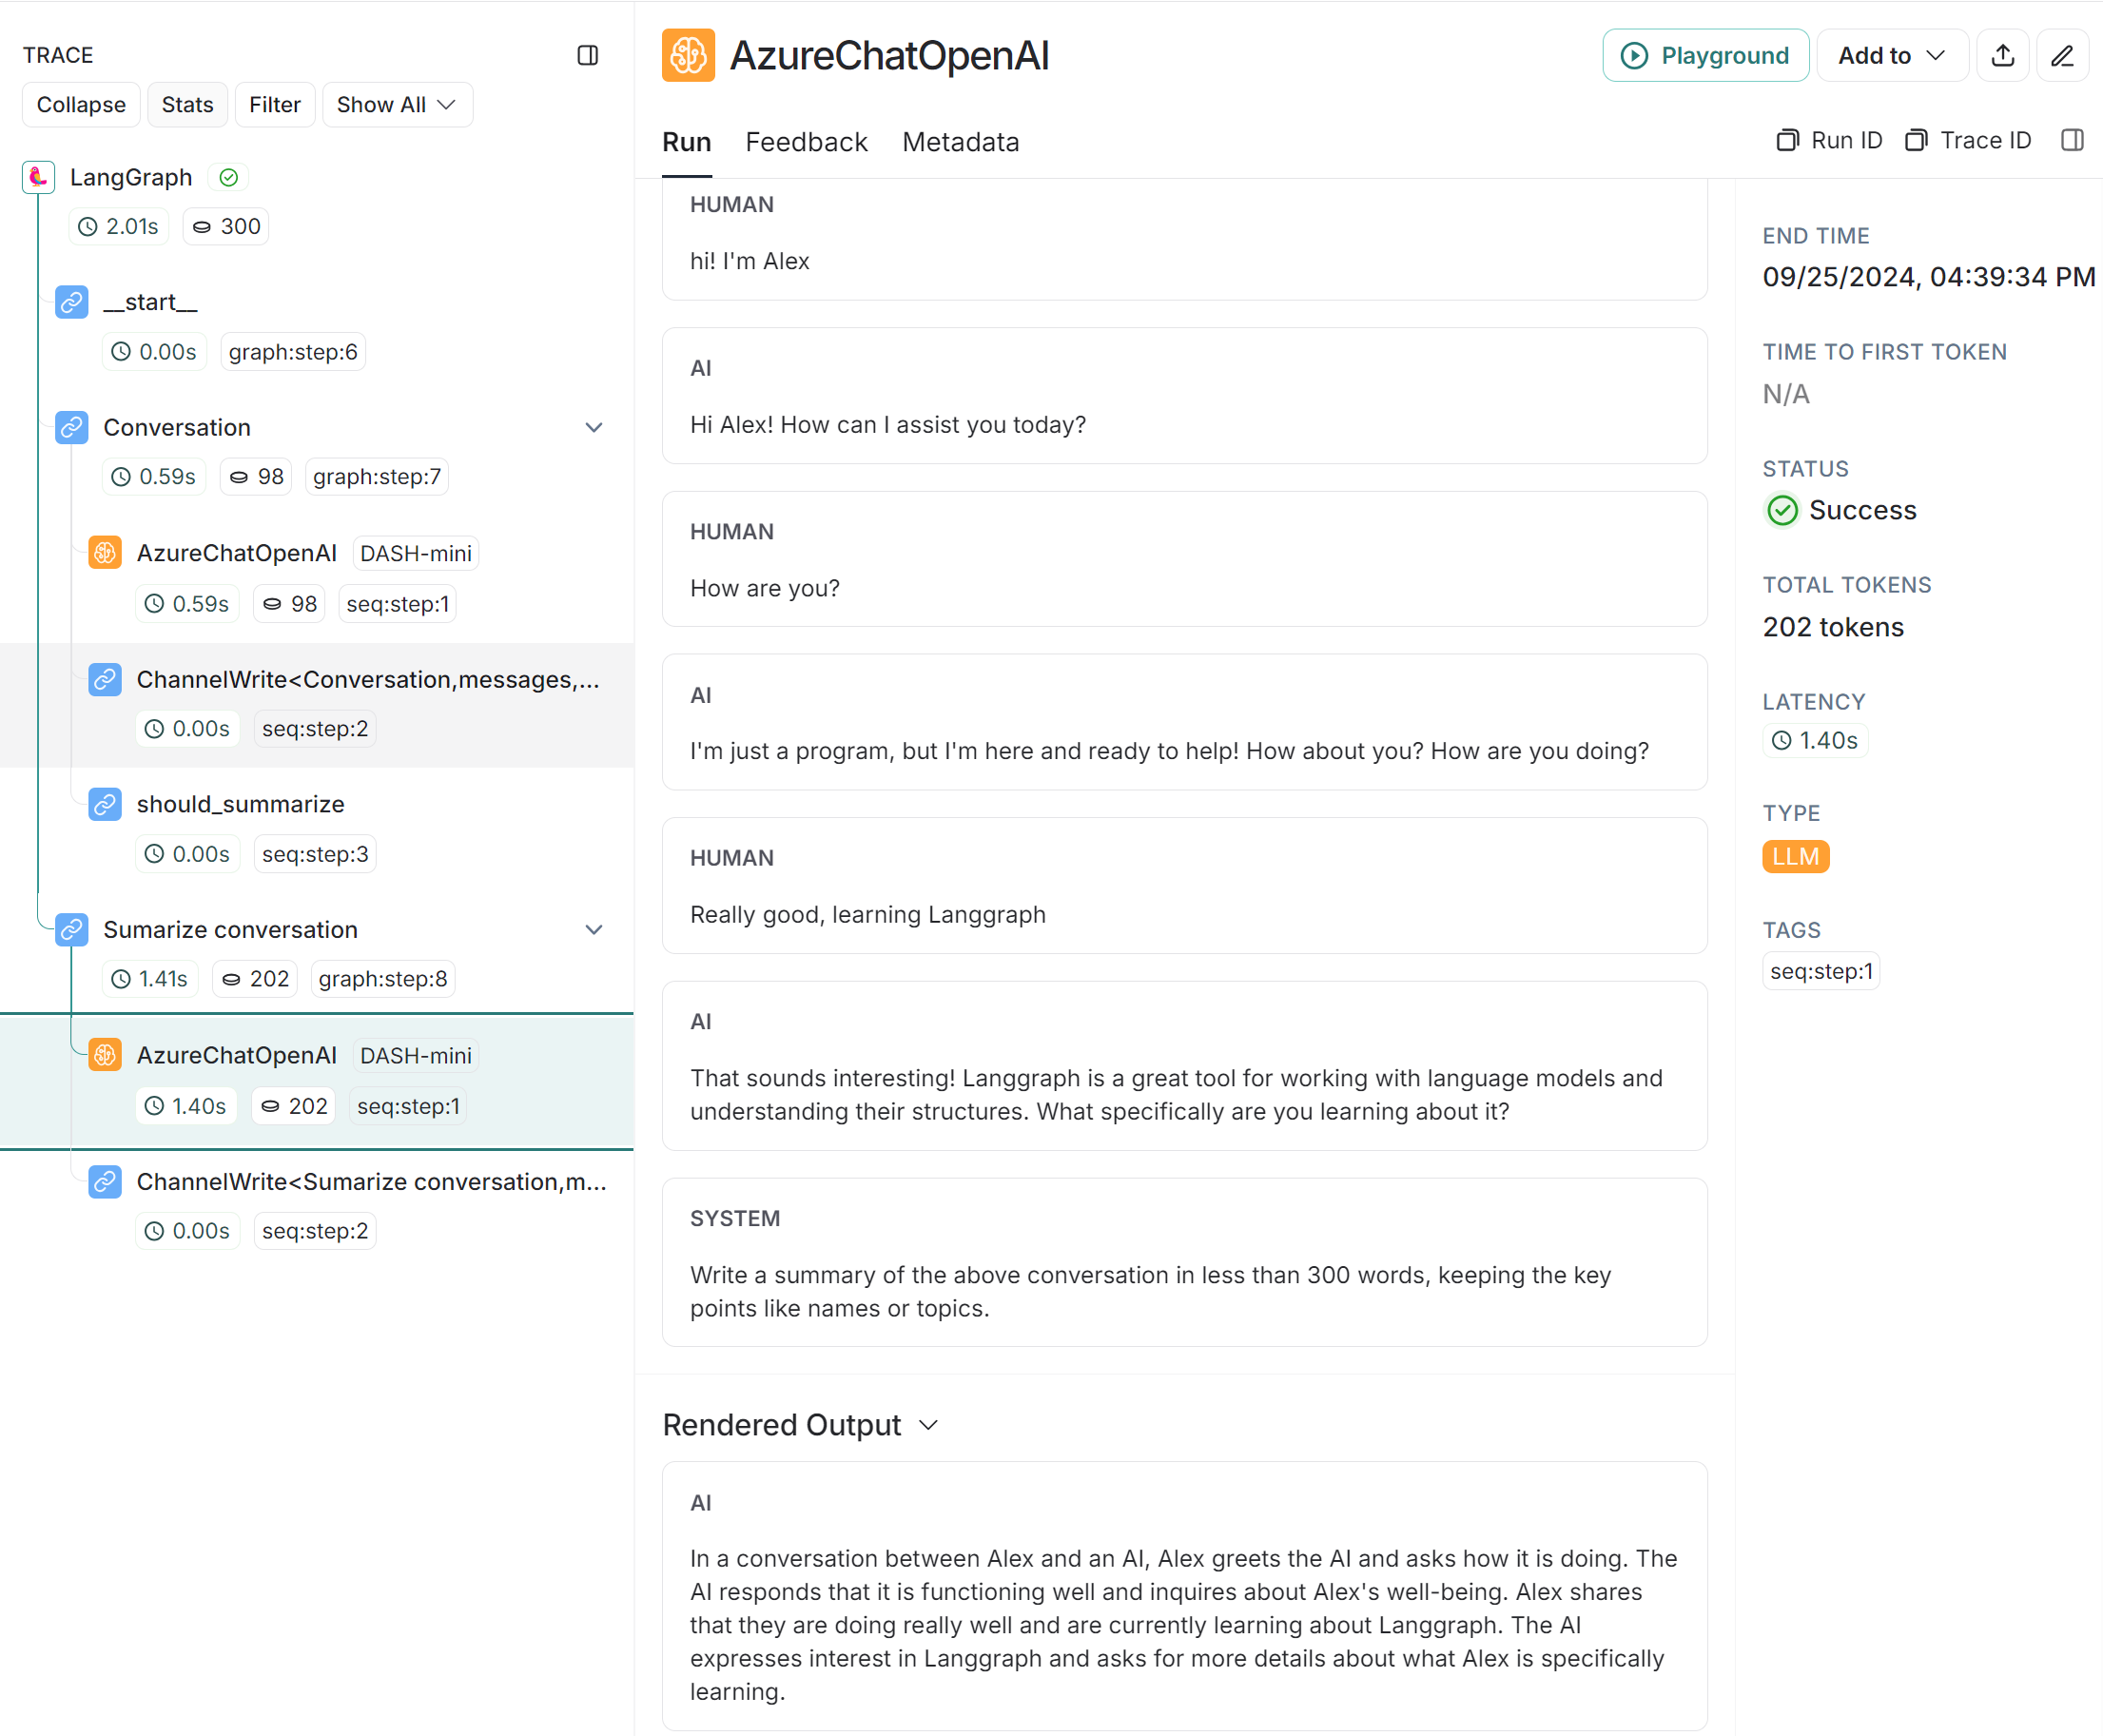

In [18]:
call_agent("I am working with memory states")

================================== Ai Message ==================================

That’s fascinating! Memory states are crucial for managing context and improving the performance of language models. Are you focusing on how to implement them, or are you exploring their theoretical aspects?


In [19]:
call_agent("I am just trying to build an agent with the ability to remember the things we talk about.")

================================== Ai Message ==================================

That sounds like a great project! Building an agent with memory can enhance its ability to provide personalized responses and maintain context over conversations. Are you using any specific techniques or frameworks to implement the memory functionality?


In [20]:
call_agent("What do you think about AI agents?")

================================== Ai Message ==================================

AI agents can be incredibly powerful tools for enhancing user experiences. They can provide personalized interactions, automate tasks, and assist with information retrieval. The ability to remember past interactions, as you're working on, can make them even more effective by allowing for context-aware conversations. However, it's also important to consider ethical implications, such as user privacy and data security. Overall, when designed thoughtfully, AI agents can significantly improve how we interact with technology. What are your thoughts on them?


In [21]:
graph.get_state(config).values.get("summary")

"In a conversation between Alex and an AI, Alex greets the AI and asks how it is doing. The AI responds that it is functioning well and inquires about Alex's well-being. Alex shares that they are doing really well and are currently learning about Langgraph. The AI expresses interest in Langgraph and asks for more details about what Alex is specifically learning.\n\nAlex mentions that they are working with memory states, which are crucial for managing context and improving the performance of language models. The AI asks whether Alex is focusing on implementing memory states or exploring their theoretical aspects. Alex clarifies that they are trying to build an agent with the ability to remember the things they talk about, which can enhance the agent's ability to provide personalized responses and maintain context over conversations. The AI expresses enthusiasm for Alex's project and inquires if they are using any specific techniques or frameworks to implement the memory functionality.\n

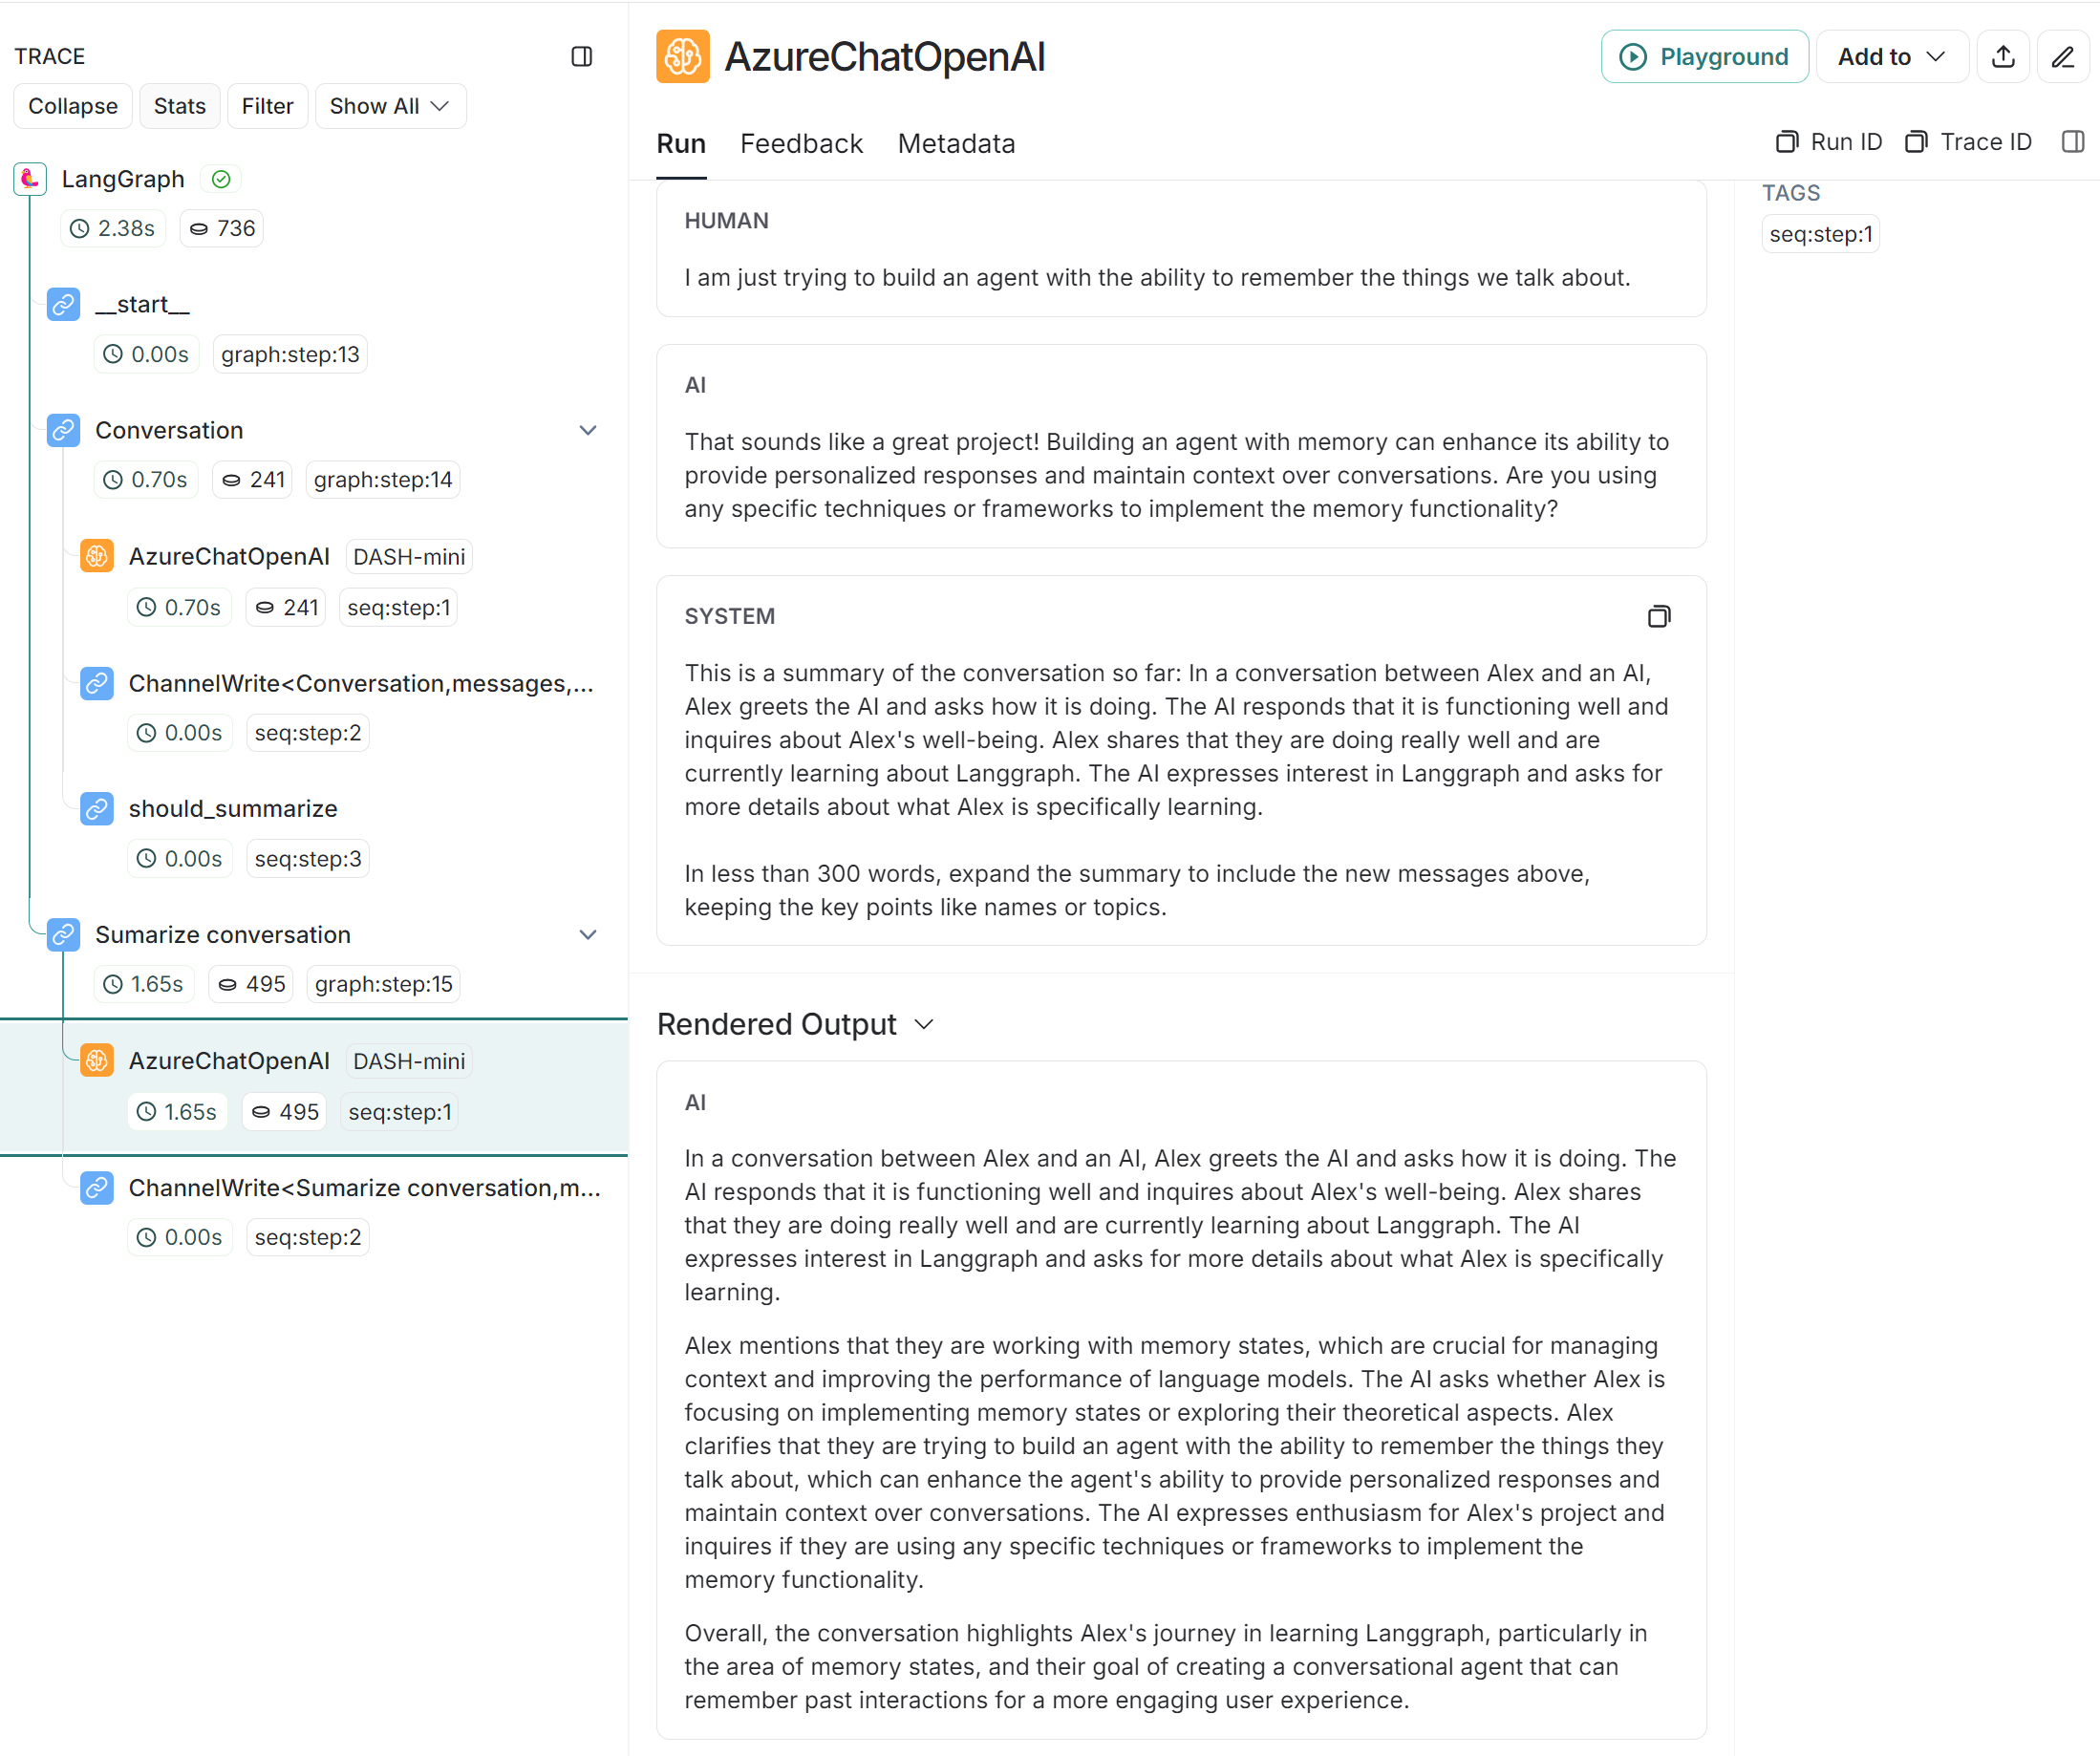